In [534]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [535]:
np.random.seed(42)

NUM_USERS = 2000
MAX_SESSIONS = 15

events = ["login", "view", "click", "add_to_cart", "purchase", "logout"]
devices = ["desktop","ios","android"]
countries = ["India", "US", "UK", "Canada"]

rows = []
start_date = datetime(2024, 1, 1)

for user_id in range(1, NUM_USERS + 1):

    sessions = np.random.randint(3, MAX_SESSIONS)
    last_time = start_date + timedelta(days=np.random.randint(0, 60))

    for s in range(sessions):
        session_id = f"s_{user_id}_{s}"
        event_count = np.random.randint(2, 8)

        for e in range(event_count):
            event = random.choice(events)

            rows.append([
                user_id,
                event,
                last_time,
                session_id,
                random.choice(devices),
                random.choice(countries)
            ])

            last_time += timedelta(minutes=np.random.randint(1, 10))

        # realistic session gap
        last_time += timedelta(days=np.random.randint(1, 5))

df = pd.DataFrame(rows, columns=[
    "user_id", "event_type", "timestamp",
    "session_id", "device", "country"
])


In [536]:
df.head()

,user_id,event_type,timestamp,session_id,device,country
0,1,purchase,2024-02-21 00:00:00,s_1_0,desktop,Canada
1,1,view,2024-02-21 00:08:00,s_1_0,desktop,US
2,1,logout,2024-02-21 00:13:00,s_1_0,ios,US
3,1,add_to_cart,2024-02-21 00:20:00,s_1_0,android,US
4,1,logout,2024-02-21 00:23:00,s_1_0,ios,UK


In [537]:
df.describe()

,user_id,timestamp
count,75976.000000,75976
mean,996.668264,2024-02-10 20:18:20.020269568
min,1.000000,2024-01-01 00:00:00
25%,505.750000,2024-01-27 00:16:45
50%,997.000000,2024-02-11 00:19:00
75%,1488.000000,2024-02-26 00:36:00
max,2000.000000,2024-04-08 04:25:00
std,573.656938,NaN


In [538]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75976 entries, 0 to 75975
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     75976 non-null  int64         
 1   event_type  75976 non-null  object        
 2   timestamp   75976 non-null  datetime64[ns]
 3   session_id  75976 non-null  object        
 4   device      75976 non-null  object        
 5   country     75976 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 3.5+ MB


In [539]:
df['event_type'].value_counts()

event_type
click          12847
add_to_cart    12725
logout         12638
login          12635
view           12573
purchase       12558
Name: count, dtype: int64

In [540]:
max_date = df['timestamp'].max()

last_activity = df.groupby('user_id')['timestamp'].max().reset_index()

last_activity['churn'] = (
    (max_date - last_activity['timestamp']).dt.days > 30
).astype(int)

df = df.merge(last_activity[['user_id','churn']], on='user_id')


In [541]:
oh = OneHotEncoder(sparse_output= False)
le = LabelEncoder()

oh.fit(df[['country']])
trans_country = oh.transform(df[['country']])

df['event_type'] = pd.DataFrame(le.fit_transform(df['event_type']))

In [542]:
trans_pd_country = pd.DataFrame(
    trans_country,
    columns=oh.get_feature_names_out(['country'])
)

In [543]:
trans_pd_country.sample(10)

,country_Canada,country_India,country_UK,country_US
3630,0.0,0.0,0.0,1.0
21516,0.0,1.0,0.0,0.0
75611,0.0,1.0,0.0,0.0
69752,0.0,0.0,0.0,1.0
56058,0.0,0.0,0.0,1.0
73875,0.0,0.0,0.0,1.0
62023,0.0,0.0,0.0,1.0
11199,0.0,0.0,0.0,1.0
32200,0.0,1.0,0.0,0.0
32379,1.0,0.0,0.0,0.0


In [544]:
df = df.drop('country' , axis=1)

In [545]:
df = pd.concat([df,trans_pd_country] , axis= 1)

In [546]:
df['churn'].value_counts()

churn
1    57014
0    18962
Name: count, dtype: int64

In [547]:
oh.fit(df[['device']])
device_pd= pd.DataFrame(oh.transform(df[['device']]),columns = oh.get_feature_names_out(['device']))

In [548]:
df = df.drop('device',axis=1)
df=pd.concat([df,device_pd],axis=1)

In [549]:
df.head()

,user_id,event_type,timestamp,session_id,churn,country_Canada,country_India,country_UK,country_US,device_android,device_desktop,device_ios
0,1,4,2024-02-21 00:00:00,s_1_0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,5,2024-02-21 00:08:00,s_1_0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1,3,2024-02-21 00:13:00,s_1_0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1,0,2024-02-21 00:20:00,s_1_0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1,3,2024-02-21 00:23:00,s_1_0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [550]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

df = df.drop('timestamp', axis=1)


In [551]:
user_df = df.groupby('user_id').agg({
    'session_id': 'nunique',
    'event_type': 'count',
    'hour': 'mean',
    'is_weekend': 'mean'
}).rename(columns={
    'session_id': 'num_sessions',
    'event_type': 'total_events'
}).reset_index()


In [552]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
trans_event = pd.DataFrame(le.fit_transform(df['event_type']),columns = ['event_type'])

In [553]:
df.sample(20)

,user_id,event_type,session_id,churn,country_Canada,country_India,country_UK,country_US,device_android,device_desktop,device_ios,hour,day_of_week,is_weekend
39118,1024,5,s_1024_10,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4,2,0
56195,1468,2,s_1468_0,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,1,0
37423,982,4,s_982_2,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,4,0
6041,158,4,s_158_3,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1,3,0
47932,1254,5,s_1254_7,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3,5,1
62968,1646,2,s_1646_3,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1,4,0
5081,133,4,s_133_1,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,5,1
44325,1159,3,s_1159_0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,4,0
74968,1973,5,s_1973_0,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,5,1
69582,1830,3,s_1830_1,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,3,0


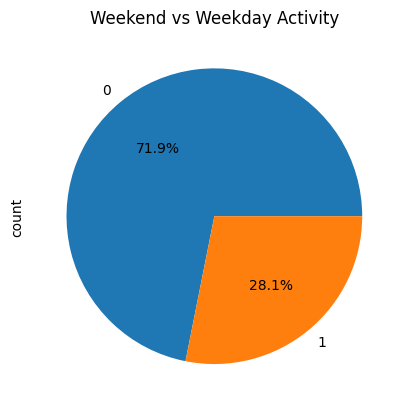

In [554]:
df['is_weekend'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Weekend vs Weekday Activity')
plt.show()


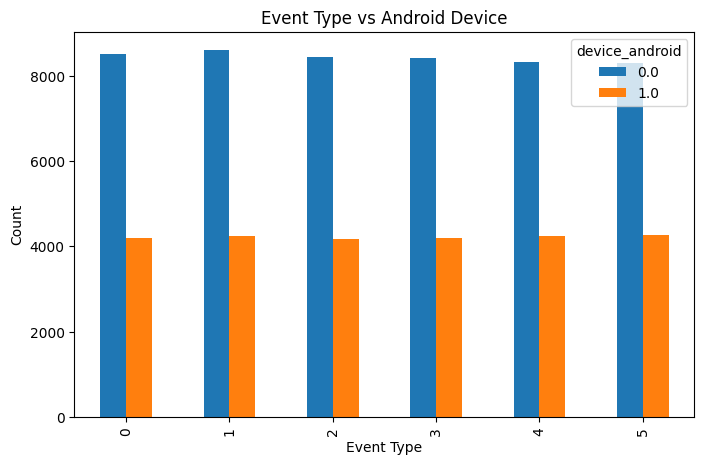

In [555]:
event_device = pd.crosstab(df['event_type'], df['device_android'])
event_device.plot(kind='bar', figsize=(8,5))
plt.title('Event Type vs Android Device')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()

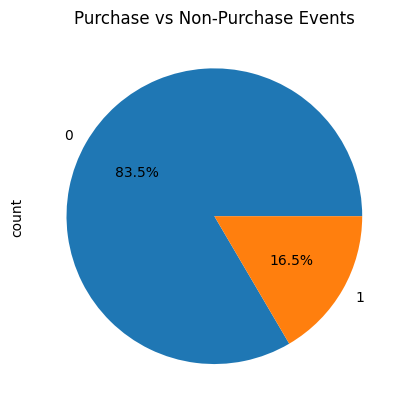

In [556]:
df['is_purchase'] = (df['event_type'] == 5).astype(int)
df['is_purchase'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Purchase vs Non-Purchase Events')
plt.show()

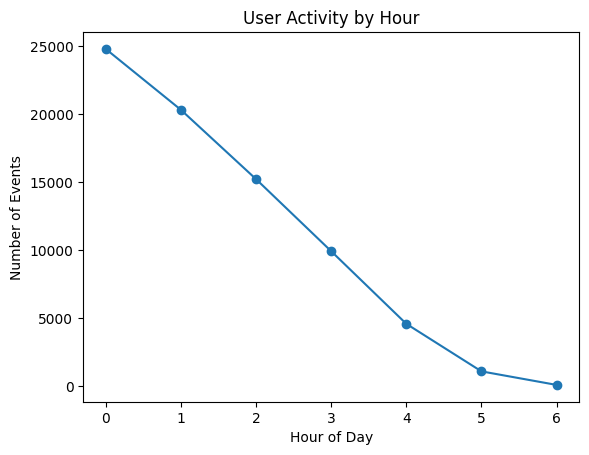

In [557]:
df.groupby('hour').size().plot(kind='line', marker='o')
plt.title('User Activity by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Events')
plt.show()

# Modeling

In [558]:
from sklearn.model_selection import train_test_split


X = df.drop(['churn','is_purchase','session_id','user_id'], axis=1)
y = df['churn']

X_train , X_test , y_train , y_test = train_test_split(X,y,test_size = 0.2, random_state = 42, stratify=y)

In [559]:
y.value_counts()

churn
1    57014
0    18962
Name: count, dtype: int64

In [560]:
df['event_type'].isnull().sum()

np.int64(0)

In [561]:
df.head()

,user_id,event_type,session_id,churn,country_Canada,country_India,country_UK,country_US,device_android,device_desktop,device_ios,hour,day_of_week,is_weekend,is_purchase
0,1,4,s_1_0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,2,0,0
1,1,5,s_1_0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,2,0,1
2,1,3,s_1_0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,2,0,0
3,1,0,s_1_0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,2,0,0
4,1,3,s_1_0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,2,0,0


In [562]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)


rf.fit(X_train, y_train)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))
print("Accuracy Score: ",accuracy_score(y_pred,y_test))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.29      0.45      0.35      3793
           1       0.77      0.62      0.69     11403

    accuracy                           0.58     15196
   macro avg       0.53      0.54      0.52     15196
weighted avg       0.65      0.58      0.61     15196

Accuracy Score:  0.5806133192945512


array([[1719, 2074],
       [4299, 7104]])

In [563]:
from sklearn.metrics import roc_auc_score

print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))


ROC AUC: 0.5522232841487706


In [571]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(y_train[y_train==0]) / len(y_train[y_train==1])),
    random_state=42,
    eval_metric='logloss'
)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
y_probs = xgb.predict_proba(X_test)[:,1]


In [572]:
print(classification_report(y_test, xgb_pred))
print("Accuracy:", accuracy_score(y_test, xgb_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_probs))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred))


              precision    recall  f1-score   support

           0       0.31      0.51      0.39      3793
           1       0.79      0.62      0.70     11403

    accuracy                           0.60     15196
   macro avg       0.55      0.57      0.54     15196
weighted avg       0.67      0.60      0.62     15196

Accuracy: 0.5965385627796789
ROC-AUC: 0.5864273995638402
Confusion Matrix:
 [[1945 1848]
 [4283 7120]]
